In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import pandas as pd
import os
import difPy
import hashlib
from collections import Counter
import random
import scipy.stats as stats
from PIL import Image


%matplotlib widget

In [2]:
meta_data_file_path = "/Training/train.csv"
original_data_folder = "data"
output_folder = "../output/pre_analysis"
pdf_folder = "/pdf"
csv_folder = "/csv"
meta_data_testing_file_path = "/Testing/train.csv"


In [3]:
colors = sns.color_palette("Set2")

In [4]:
meta_data_df = pd.read_csv("../" + original_data_folder + meta_data_file_path)

In [5]:
labels = list(meta_data_df["Label"].unique())
planes = list(meta_data_df["Plane"].unique())

### Show random sample of images

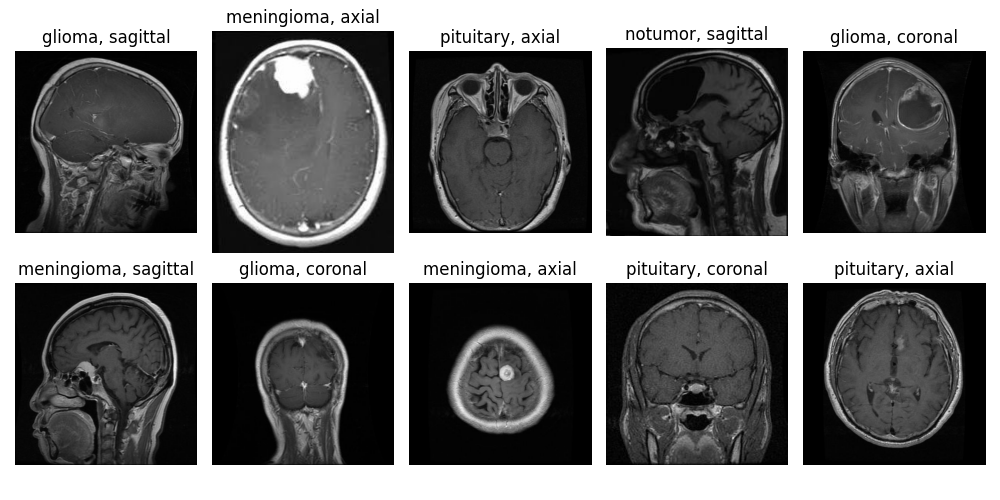

In [6]:
def view_mulitiple_samples(file_names_list, count=10, fig_size=(9, 4)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    random_samples = random.sample(file_names_list, count)   
    fig = plt.figure(figsize=fig_size)

    counter = 1
    for sample in random_samples:
        plt.subplot(rows, 5, counter)
        plt.title(sample.split("/")[-2] + ", " + meta_data_df[meta_data_df["Path"] == sample]["Plane"].item())
        plt.axis('off')
        plt.imshow(cv2.imread(sample))
        counter+=1
    plt.tight_layout()
    plt.savefig(output_folder + pdf_folder + "/sample_images.pdf")
    return

view_mulitiple_samples(list(meta_data_df["Path"]), count=10, fig_size=(10, 5))

### Show datadistribution for planes and labels(tumor types/ no tumor)

In [8]:
tumor_plane_count_df = pd.DataFrame()

for label in labels:
    tumor_plane_count_df.loc["total", "total"] = len(meta_data_df)
    tumor_plane_count_df.loc[label, "total"] = len(meta_data_df[(meta_data_df["Label"] == label)])
    for plane in planes:
        tumor_plane_count_df.loc[label, plane] = len(meta_data_df[(meta_data_df["Plane"] == plane) & (meta_data_df["Label"] == label)])
        tumor_plane_count_df.loc["total", plane] = len(meta_data_df[(meta_data_df["Plane"] == plane)])

tumor_plane_count_df.to_csv(output_folder + csv_folder + "/tumor_plane_count.csv")
tumor_plane_count_df

,total,sagittal,axial,coronal
total,5712.0,1438.0,2850.0,1424.0
glioma,1321.0,354.0,482.0,485.0
meningioma,1339.0,474.0,436.0,429.0
pituitary,1457.0,521.0,426.0,510.0
notumor,1595.0,89.0,1506.0,0.0


### Visualise the data distribution separated by their plane and in total

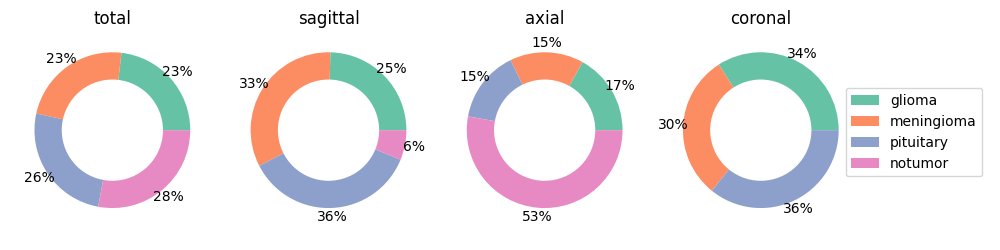

In [9]:
plt.close()
fig = plt.figure(figsize=(10,2.5))
counter = 1
for col in tumor_plane_count_df.columns:
    plt.subplot(1, 4, counter)
    plt.title(col)
    wedges = plt.pie(tumor_plane_count_df[~tumor_plane_count_df.index.isin(["total"])][col], autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', colors=colors, pctdistance=1.12)
    centre_circle = plt.Circle((0,0),0.65,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    counter += 1
labels = tumor_plane_count_df[~tumor_plane_count_df.index.isin(["total"])].index
plt.legend(labels=labels, bbox_to_anchor=(.9,.75), ncol=1)
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/data_distribution_plane.pdf")
plt.show()

### Visualise the data distribution separated by the type of tumor/ no tumor and in total

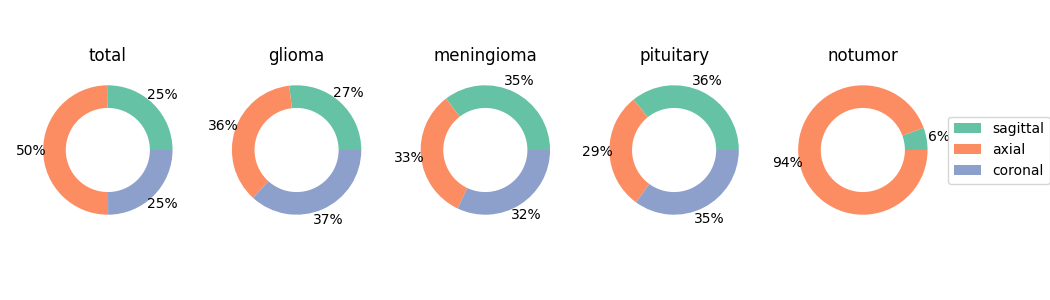

In [10]:
plt.close()
fig = plt.figure(figsize=(10.5,3))
counter = 1

plane_list = list(tumor_plane_count_df.columns)
plane_list.remove("total")

for col in tumor_plane_count_df.T.columns:
    plt.subplot(1, 5, counter)
    plt.title(col)
    wedges = plt.pie(tumor_plane_count_df.T[~tumor_plane_count_df.T.index.isin(["total"])][col], autopct=lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '',  colors=colors, pctdistance=1.19)
    counter += 1
    centre_circle = plt.Circle((0,0),0.65,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
plt.legend(labels=plane_list, bbox_to_anchor=(1.7, .75), ncol=1)
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/data_distribution_label.pdf")
plt.show()

#### Find duplicates
##### Difpy package

In [11]:
dif = difPy.build("../data/Training/")
search = difPy.search(dif)

difPy preparing files: [100%]
difPy searching files: [100%]


In [188]:
print("Amount of duplicates found by difPy package: ", len(search.result))

Amount of duplicates found by difPy package:  155


In [189]:
search_result = search.result
all_duplicate_file_paths = []
for original_id in search_result:
    matches = search_result[original_id]["matches"]
    for match in matches:
        duplicate_file_path = matches[match]["location"]
        if duplicate_file_path not in all_duplicate_file_paths:
            all_duplicate_file_paths.append(matches[match]["location"])

#### Total duplicates to be deleted

In [190]:
print("Amount of total duplicate images to be deleted:", len(all_duplicate_file_paths))

Amount of total duplicate images to be deleted: 207


#### Duplicate summary

In [191]:
duplicate_amount_df = pd.DataFrame(columns=["Amount"])
duplicate_amount_df.loc["difPy", "Amount"] = len(search.result)
duplicate_amount_df.loc["total", "Amount"] = len(all_duplicate_file_paths)

duplicate_amount_df.to_csv(output_folder + csv_folder + "/duplicate_amount.csv")
duplicate_amount_df

,Amount
difPy,155
total,207


#### Visualise sample of duplicates

/var/folders/qv/tqh1ls9x7nlgts1pcbvs42140000gn/T/ipykernel_75002/3197311357.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_sample = random.sample(search.result.keys(), 5)


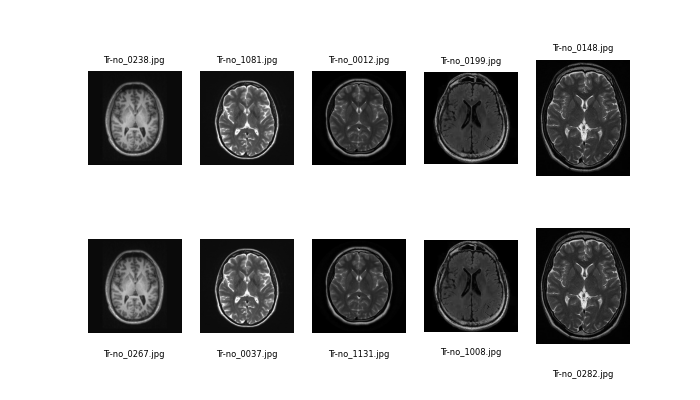

In [192]:
plt.close()
random_sample = random.sample(search.result.keys(), 5)
cols = len(random_sample)
rows = 2
fig = plt.figure(figsize=(7, 4))
counter = 1
for col in range(cols):
    duplicates = search.result[random_sample[col]]
    plt.subplot(rows, cols, counter)
    plt.title(duplicates["location"].split("/")[-1]).set_size(6)
    plt.axis('off')
    plt.imshow(cv2.imread(duplicates["location"]))
    counter += 1

for col in range(cols):
    duplicates = search.result[random_sample[col]]
    duplicate_id = next(iter(duplicates["matches"])) # only show first duplicate
    location = "./" + duplicates["matches"][duplicate_id]["location"]
    plt.subplot(rows, cols, counter)
    plt.title(duplicates["matches"][duplicate_id]["location"].split("/")[-1], y=-0.35).set_size(6)
    plt.axis('off')
    plt.imshow(cv2.imread("./" + duplicates["matches"][duplicate_id]["location"]))
    counter += 1

plt.savefig(output_folder + pdf_folder + "/sample_duplicates.pdf")
plt.show()

### Check color of images

In [12]:
def isgray(imgpath):
    # Checks if all three channels are equal.
    img = Image.open(imgpath).convert('RGB')
    w, h = img.size
    for i in range(w):
        for j in range(h):
            r, g, b = img.getpixel((i,j))
            if r != g != b: 
                return False, cv2.imread(imgpath)
    return True, cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2GRAY)

In [194]:
# Return all images with RGB
color_img_counter = 0
color_dir_list = []
shape_list = []

for file in list(meta_data_df["Path"]):
    is_gray, img = isgray(file)
    if not is_gray:
        color_dir_list.append(file.split("/")[-3] + ", " + file.split("/")[-2])
        color_img_counter += 1
    shape_list.append(img.shape)

In [195]:
print("Location of images in RGB and their amount")
color_dict = dict(Counter(color_dir_list))
rbg_distribution_df = pd.DataFrame()
for location in color_dict:
    rbg_distribution_df.loc[location, "Amount"] = color_dict[location]

rbg_distribution_df.to_csv(output_folder + csv_folder + "/rgb_distribution_count.csv")
rbg_distribution_df

Location of images in RGB and their amount


,Amount
"Training, notumor",92.0


### Check size of images

#### Heights, Widths of all images

In [13]:
print("\nDifferent dimensions and their occurence in the dataset:")
meta_data_df[["Height", "Width"]].astype(str).agg('x'.join, axis=1).value_counts().to_frame().to_csv(output_folder + csv_folder + "/height_width_distribution.csv")
meta_data_df[["Height", "Width"]].astype(str).agg('x'.join, axis=1).value_counts().to_frame()


Different dimensions and their occurence in the dataset:


,count
512x512,3955
225x225,268
630x630,77
236x236,53
251x201,43
...,...
245x206,1
235x200,1
483x430,1
212x238,1


##### Percentage for Width, Height = 512 (most common size)

In [33]:
round(len(meta_data_df[(meta_data_df["Height"] == 512) & (meta_data_df["Width"] == 512)])/len(meta_data_df) * 100, 1)

69.2

##### Percentage for Width, Height = 225 (second most common size)

In [32]:
round(len(meta_data_df[(meta_data_df["Height"] == 225) & (meta_data_df["Width"] == 225)])/len(meta_data_df) * 100, 1)

4.7

#### Images where Width == Height

In [197]:
print("Images and their occurences for width==height:")
meta_data_df[(meta_data_df["Height"] == meta_data_df["Width"])][["Height", "Width"]].astype(str).agg('x'.join, axis=1).value_counts().to_frame().to_csv(output_folder + csv_folder + "/height=width_distribution.csv")
meta_data_df[(meta_data_df["Height"] == meta_data_df["Width"])][["Height", "Width"]].astype(str).agg('x'.join, axis=1).value_counts().to_frame()

Images and their occurences for width==height:


,count
512x512,3955
225x225,268
630x630,77
236x236,53
442x442,37
192x192,27
256x256,26
680x680,13
350x350,11
1024x1024,5


#### Images where width == height (No-Tumor)

In [198]:
meta_data_df[(meta_data_df["Height"] == meta_data_df["Width"]) & (meta_data_df["Label"] == "notumor")][["Height", "Width"]].astype(str).agg('x'.join, axis=1).value_counts().to_frame().to_csv(output_folder + csv_folder + "/height=width_notumor_distribution.csv")
len(meta_data_df[(meta_data_df["Height"] == meta_data_df["Width"]) & (meta_data_df["Label"] == "pituitary")][["Height", "Width"]])#.astype(str).agg('x'.join, axis=1).value_counts().to_frame()

1450

In [199]:
meta_data_df[(meta_data_df["Height"] <= meta_data_df["Width"] * 1.1) & (meta_data_df["Height"] >= meta_data_df["Width"] * 0.9) & (meta_data_df["Width"] <= meta_data_df["Height"] * 1.1) & (meta_data_df["Width"] >= meta_data_df["Height"] * 0.9)& (meta_data_df["Label"] == "notumor")]#[["Height", "Width"]].astype(str).agg('x'.join, axis=1).value_counts().to_frame()

,Image ID,Label,Plane,Width,Height,Path
4117,Tr-no_0482,notumor,axial,225,225,../data/Training/notumor/Tr-no_0482.jpg
4118,Tr-no_0641,notumor,axial,630,630,../data/Training/notumor/Tr-no_0641.jpg
4120,Tr-no_0711,notumor,axial,192,192,../data/Training/notumor/Tr-no_0711.jpg
4121,Tr-no_0746,notumor,axial,630,630,../data/Training/notumor/Tr-no_0746.jpg
4122,Tr-no_0477,notumor,axial,225,225,../data/Training/notumor/Tr-no_0477.jpg
...,...,...,...,...,...,...
5707,Tr-no_1294,notumor,axial,225,225,../data/Training/notumor/Tr-no_1294.jpg
5708,Tr-no_0970,notumor,axial,234,225,../data/Training/notumor/Tr-no_0970.jpg
5709,Tr-no_1371,notumor,axial,441,442,../data/Training/notumor/Tr-no_1371.jpg
5710,Tr-no_0233,notumor,axial,207,207,../data/Training/notumor/Tr-no_0233.jpg


#### Visualise width/height distribution

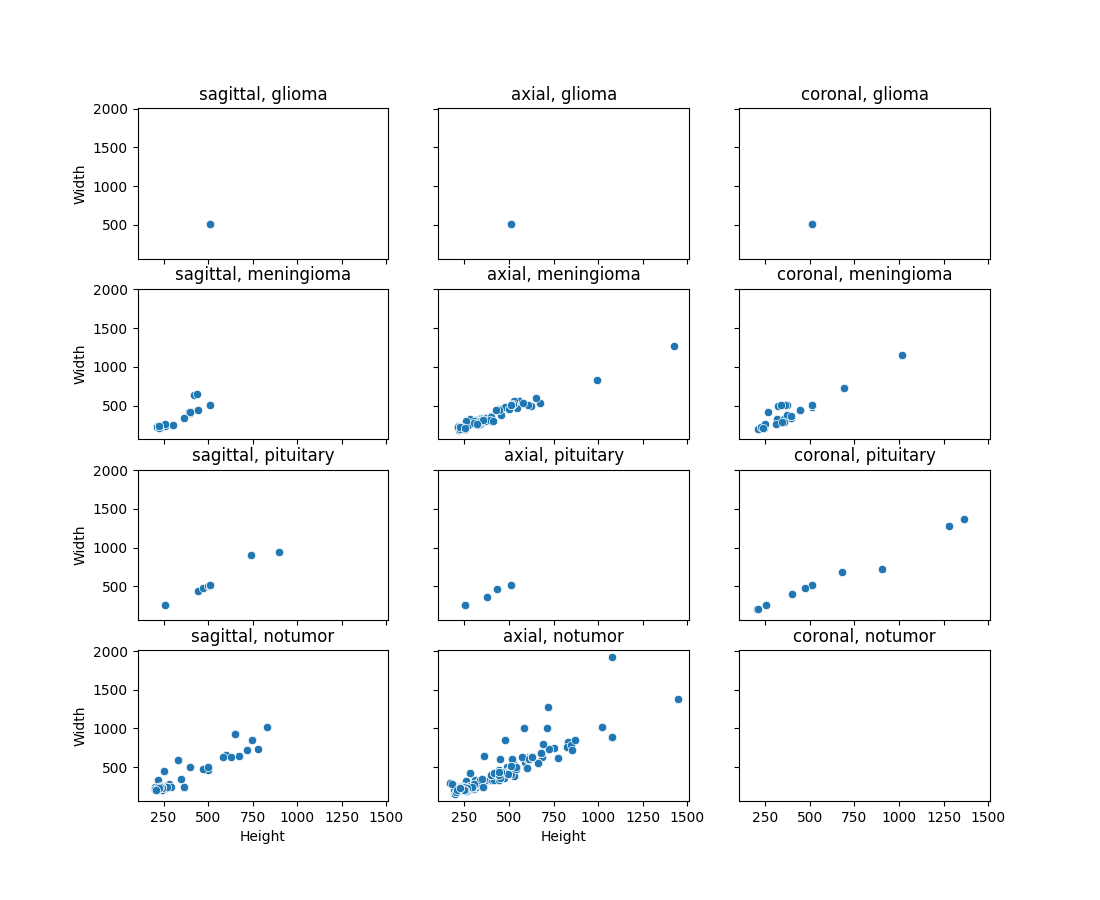

In [70]:
fig, axes = plt.subplots(nrows=len(labels), ncols=len(planes), figsize=(11, 9), sharey=True, sharex=True)

label_counter = 0
for label in labels:
    plane_counter = 0
    for plane in planes:
        sns.scatterplot(ax=axes[label_counter, plane_counter], data=meta_data_df[(meta_data_df["Label"] == label) & (meta_data_df["Plane"] == plane)], x="Height", y= "Width").set(title=plane + ", " + label)
        plane_counter +=1
    label_counter +=1

plt.savefig(output_folder + pdf_folder + "/height_width_distribution.pdf")

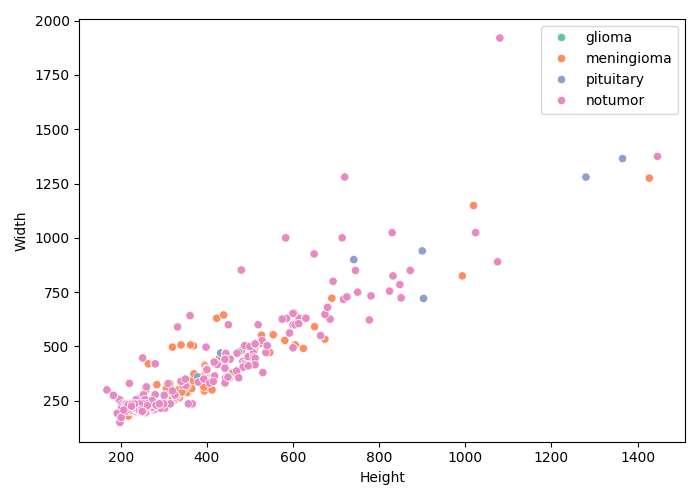

In [118]:
plt.close()
fig = plt.figure(figsize=(7,5))
g = sns.scatterplot(data=meta_data_df, x="Height", y= "Width", hue="Label", palette="Set2")

g.get_legend().set_title(None)
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/height_width_distribution_tumor.pdf")
plt.show()

### Blur detection with Laplacian variance

In [35]:
def variance_of_laplacian(image):
	# compute the Laplacian of the image and then return the focus
	# measure, which is simply the variance of the Laplacian
	return cv2.Laplacian(image, cv2.CV_64F).var()

In [36]:
def detect_bluriness(img, threshold=50):
    fm = variance_of_laplacian(img)
    # if the focus measure is less than the supplied threshold,
    # then the image should be considered "blurry"
    if fm < threshold: return True, fm
    return False, fm

In [37]:
def map_true_false_to_yes_no(bool):
    return 'yes' if bool else 'no'

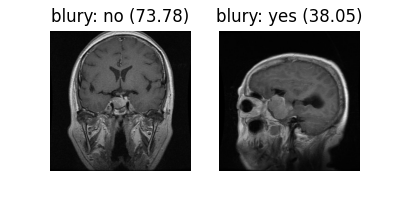

In [40]:
plt.close()

img1 = cv2.imread(meta_data_df.iloc[random.randint(0, len(meta_data_df))]["Path"], cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(meta_data_df.iloc[random.randint(0, len(meta_data_df))]["Path"], cv2.IMREAD_GRAYSCALE)

is_blury1, bluriness1 = detect_bluriness(img1)
is_blury2, bluriness2 = detect_bluriness(img2)

while is_blury1 == is_blury2:
    img2 = cv2.imread(meta_data_df.iloc[random.randint(0, len(meta_data_df))]["Path"], cv2.IMREAD_GRAYSCALE)
    is_blury2, bluriness2 = detect_bluriness(img2)

fig = plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("blury: " + map_true_false_to_yes_no(is_blury1) + f' ({round(bluriness1, 2)})')
plt.axis('off')
plt.imshow(img1, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("blury: " + map_true_false_to_yes_no(is_blury2) + f' ({round(bluriness2, 2)})')
plt.axis('off')
plt.imshow(img2, cmap="gray")

plt.savefig(output_folder + pdf_folder + "/bluriness_example.pdf")
plt.show()

In [39]:
bluriness_df = pd.DataFrame(index=meta_data_df.index)
for i, row in meta_data_df.iterrows():
    img = cv2.imread(row["Path"], cv2.IMREAD_GRAYSCALE)
    is_blury, bluriness = detect_bluriness(img)
    bluriness_df.loc[i, "isBlury"] = is_blury
    bluriness_df.loc[i, "bluriness"] = bluriness
bluriness_df

/var/folders/qv/tqh1ls9x7nlgts1pcbvs42140000gn/T/ipykernel_7669/3573791555.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  bluriness_df.loc[i, "isBlury"] = is_blury


,isBlury,bluriness
0,True,32.918440
1,False,79.260093
2,False,93.850626
3,True,29.137728
4,False,80.397980
...,...,...
5707,False,7578.185798
5708,False,657.540695
5709,False,337.731516
5710,False,738.604661


In [42]:
bluriness_df["isBlury"].value_counts().to_csv(output_folder + csv_folder + "/bluriness_amount.csv")
bluriness_count_df = bluriness_df["isBlury"].value_counts().to_frame()
bluriness_count_df

,count
isBlury,
False,4323
True,1389


In [46]:
round(bluriness_count_df.loc[True, "count"] / len(meta_data_df) * 100, 1)

24.3

### Histogram
#### Histogram for every plane/label combination with 100 samples (all plotted in the same plot)

In [116]:
def get_histogram(df, plane, tumor, axes):
    file_names = []
    if tumor == "notumor" and plane != "all":
        file_names = list(df[(df["Plane"] == plane) & (df["Label"] == tumor)]["Path"])
    elif tumor == "tumor":
        file_names = list(df[(df["Plane"] == plane) &  ~(df["Label"] == "notumor")]["Path"])
    elif plane == "all":
        file_names = list(df[(df["Label"] == tumor)]["Path"])
    elif tumor == "both":
        file_names = list(df[df["Plane"] == plane]["Path"])

    if len(file_names) > 0:
        sample_size = len(file_names) if len(file_names) < 100 else 100
        plt.yscale('log')
        for file in random.sample(file_names, sample_size):
            image = cv2.imread(file)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            if plane == "all":
                title = tumor
            else:
                title = plane + ", " + tumor
            sns.histplot(ax=axes, data=pd.DataFrame(gray.ravel()), x=0).set(title=title, xlabel ="Pixel value")
    else:
        axes.set_visible(False)

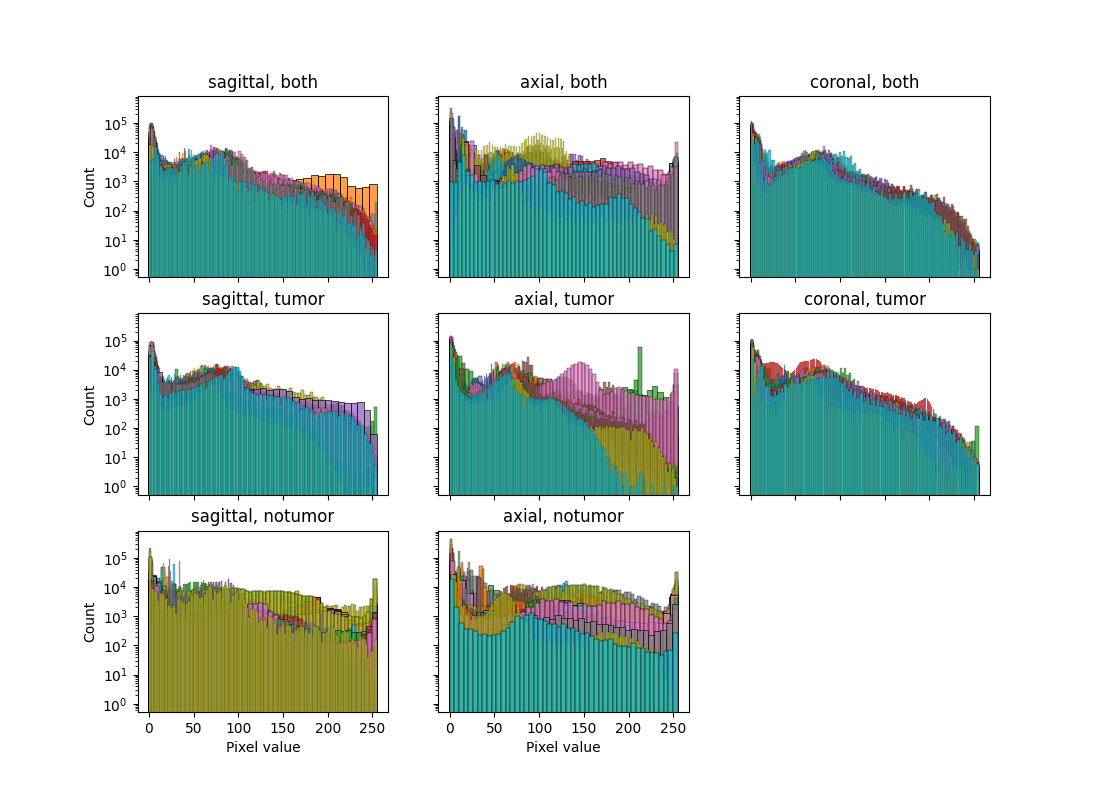

In [208]:
plt.close()
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(11, 8), sharey=True, sharex=True)
types = ["both", "tumor", "notumor"]

counter_type = 0
for type in types:
    counter_plane = 0
    for plane in planes:
        get_histogram(meta_data_df, plane, type, axes[counter_type, counter_plane])
        counter_plane += 1
    counter_type += 1
    
plt.savefig(output_folder + pdf_folder + "/histogram_plane_label.pdf")
plt.show()

#### Histogram for every tumor type/no tumor combination with 100 samples (all plotted in the same plot)

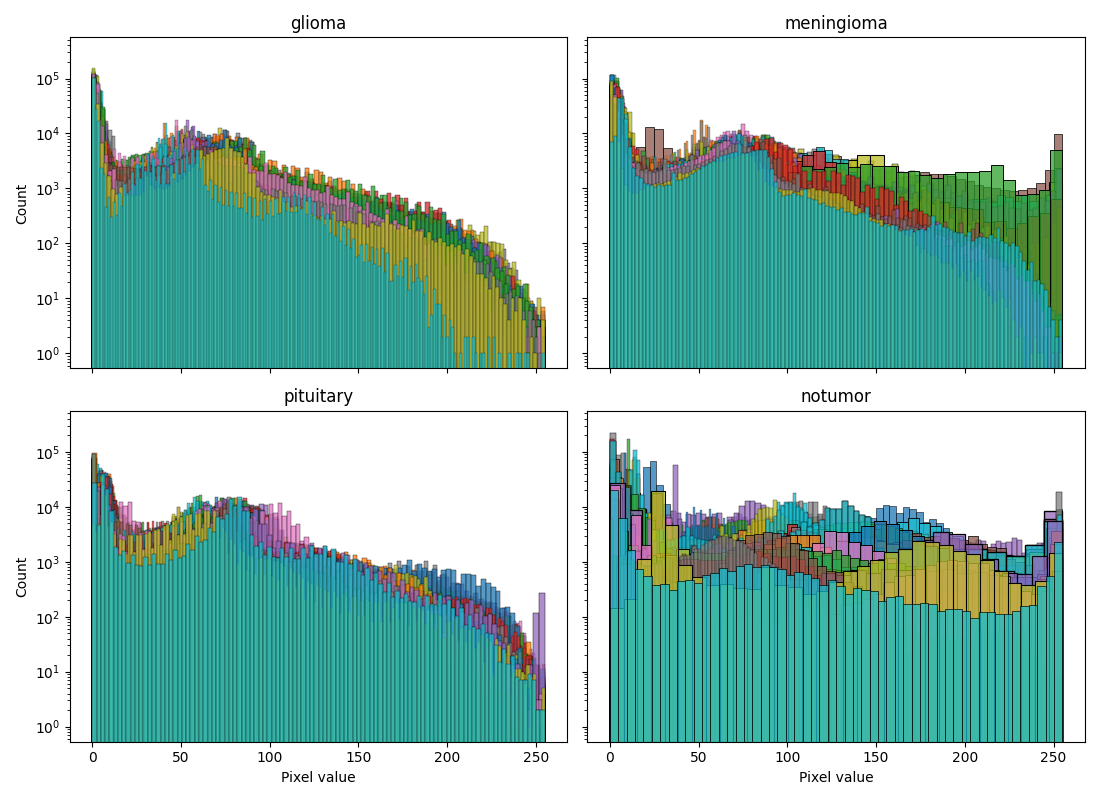

In [120]:
plt.close()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), sharey=True, sharex=True)

label_counter = 0
row_counter = 0
for label in labels:
    get_histogram(meta_data_df, "all", label, axes[row_counter, label_counter])
    if label_counter == 1:
        row_counter = 1
        label_counter = 0
    else:
        label_counter += 1
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/histogram_tumor_type.pdf")
plt.show()

#### Average normalized distribution of every label

In [93]:
def get_average_histogram_by_label(df, label):
    random_sample = random.sample(list(df[df["Label"] == label]["Path"]), 100)
    sample_df = df[df["Path"].isin(random_sample)]
    average_histogram = np.zeros(256)

    for image_path in sample_df['Path']:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Convert to grayscale
        histogram, _ = np.histogram(img, bins=256, range=(0, 255))
        for i, val in enumerate(histogram):
            average_histogram[i] += val/len(sample_df)
    return average_histogram

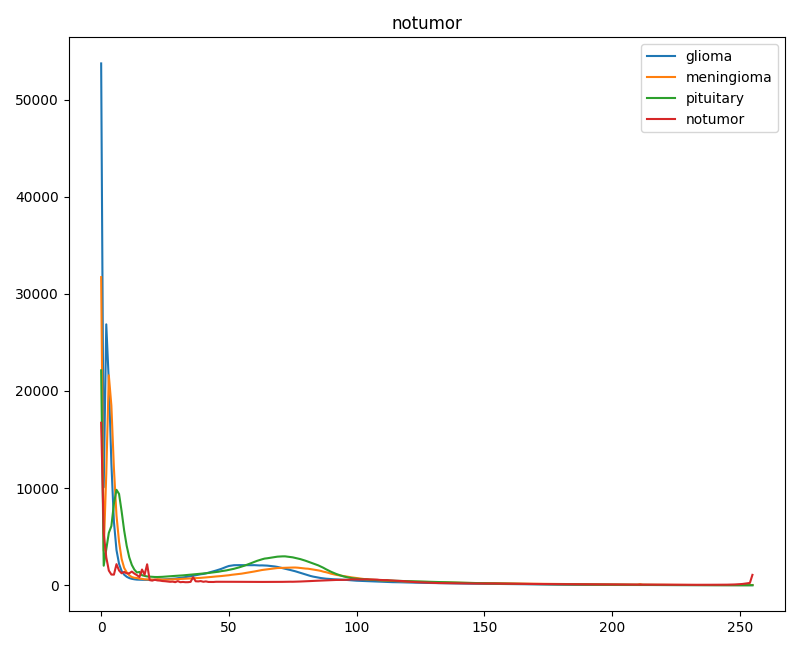

In [101]:
fig = plt.figure(figsize=(8, 6.5))

for counter, label in enumerate(labels):
    #fig = plt.subplot(2, 2, counter + 1)
    plt.plot(get_average_histogram_by_label(meta_data_df, label), label=label)
    #plt.ylim(0, 57000)
    plt.title(label)
plt.legend()
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/avg_histogram_tumor_type.pdf")
plt.show()

#### Histogram for every tumor type/no tumor combination with 100 samples (all plotted in the same plot) with pre-processed-data

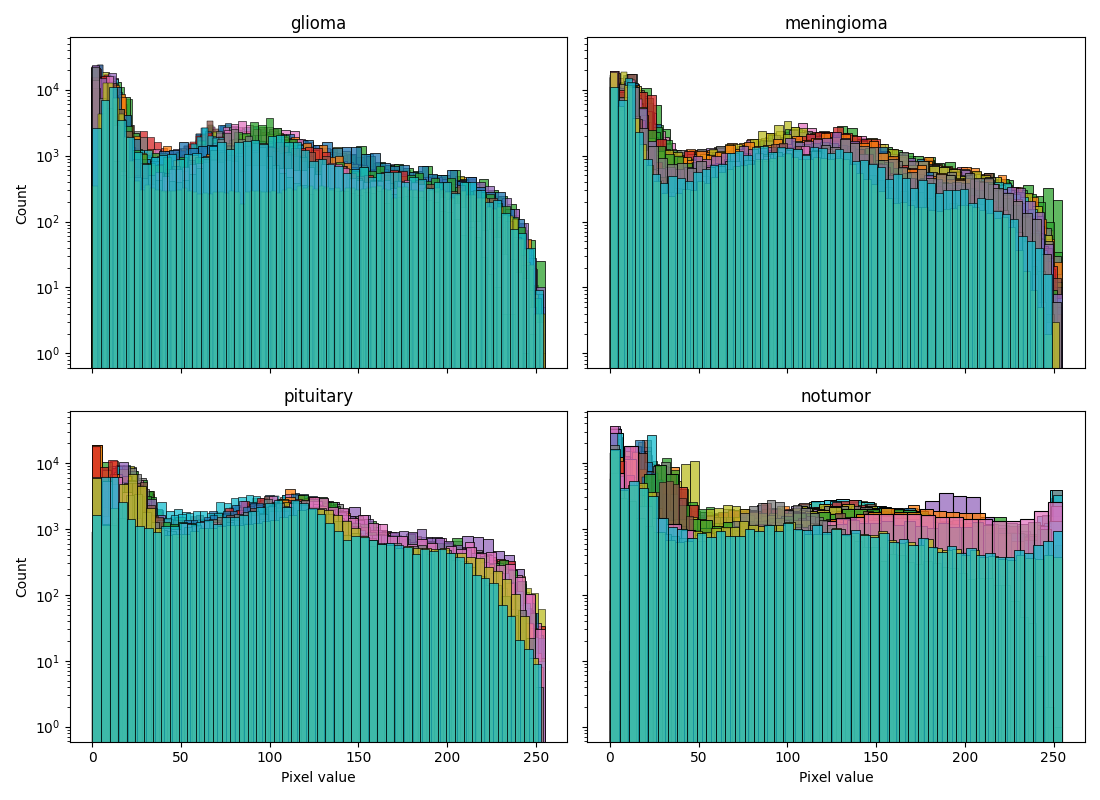

In [123]:
pre_processed_data_folder = "pre_processed_data"
pre_processed_df = pd.read_csv("../" + pre_processed_data_folder + meta_data_file_path)
plt.close()
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(11, 8), sharey=True, sharex=True)

label_counter = 0
row_counter = 0
for label in labels:
    get_histogram(pre_processed_df, "all", label, axes[row_counter, label_counter])
    if label_counter == 1:
        row_counter = 1
        label_counter = 0
    else:
        label_counter += 1
plt.tight_layout()
plt.savefig(output_folder + pdf_folder + "/preprocessed_histogram_tumor_type.pdf")
plt.show()